In [2]:
import sys
#sys.path.append('../input/imutils-054/imutils-0.5.4')

In [3]:
import imutils
import os
import cv2
import datetime
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

import pickle

In [ ]:
!curl -L "https://app.roboflow.com/ds/71bFp88puq?key=PcZgvyC2mW" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   898  100   898    0     0   2135      0 --:--:-- --:--:-- --:--:--  2138
100  453M  100  453M    0     0  84.3M      0  0:00:05  0:00:05 --:--:-- 98.1M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/108_jpg.rf.05246ca3f25e261c6cb43c798dff98d3.jpg  
 extracting: test/120_jpg.rf.f70e9d6912d11a1e8ac66f6c0d3dfca6.jpg  
 extracting: test/124_jpg.rf.9ca7e40e48d6c93ade819fa0e271d2f0.jpg  
 extracting: test/124_jpg.rf.db02a0ff2ca2a518b8660fa20c408de0.jpg  
 extracting: test/12_jpg.rf.11072aa8901ae7f5b4db10dfba43f34e.jpg  
 extracting: test/133_jpg.rf.03e4dc08801a2a6167f6ca07707d292d.jpg  
 extracting: test/137_jpg.rf.e88ac4dd4cf5999d1870a33fdbdc40de.jpg  
 extracting: test/13_jpg.rf.d599812a35f807484bd186e98f689536.jpg  
 extracting: test/159_jp

In [ ]:
classes = ['Pride Saipa131', 'pars', 'pezho206', 'pride', 'quick', 'tondar']

In [ ]:
def something(ann_path , images_path):
    data = []
    labels = []
    bboxes = []
    imagePaths = []
    #ann_path_new = ann_path + cl + "_train.csv"
    print(ann_path)
    rows = open(ann_path).read().strip().split("\n")
    rows = rows[1:]
    # loop over the rows
    for idx, row in enumerate(rows): #row = col
        # break the row into the
        # filename and bounding box coordinates
        row = row.split(",")
        filename = row[0]
        #filename = filename.split(".")[0]
        #filename = filename.split("_")[-1]
        #filename = filename + ".jpg"
        coords = row[4:]
        coords = [int(c) for c in coords]
        label = row[3]
        image_path = os.path.sep.join([images_path, filename])
        image = cv2.imread(image_path)
        (h, w) = image.shape[:2]


        Xmin = float(coords[0]) / w
        Ymin = float(coords[1]) / h
        Xmax = float(coords[2]) / w
        Ymax = float(coords[3]) / h

        # load the image
        image = load_img(image_path, target_size=(224, 224))  #color_mode="grayscale"
        image = img_to_array(image)

        data.append(image)
        labels.append(label)
        bboxes.append((Xmin, Ymin, Xmax, Ymax))
        imagePaths.append(image_path)
    return data, labels, bboxes, imagePaths

In [ ]:
'''
# show the output image
imgplot = plt.imshow(image.astype('uint8'))
plt.show()
'''

"\n# show the output image\nimgplot = plt.imshow(image.astype('uint8'))\nplt.show()\n"

In [ ]:
ann_path = "/content/train/_annotations.csv"
images_path = "/content/train"
data_train = []
labels_train = []
bboxes_train = []
imagePaths_train = []
data_train, labels_train, bboxes_train, imagePaths_train  = something(ann_path, images_path)

# convert from the range [0, 255] to [0, 1]
data_train = np.array(data_train, dtype="float32") / 255.0
# convert to numpy array
labels_train = np.array(labels_train)
bboxes_train = np.array(bboxes_train, dtype="float32")
imagePaths_train = np.array(imagePaths_train)
#*************************************************************
ann_path = "/content/valid/_annotations.csv"
images_path = "/content/valid"
data_valid = []
labels_valid = []
bboxes_valid = []
imagePaths_valid = []
data_valid, labels_valid, bboxes_valid, imagePaths_valid  = something(ann_path, images_path)

data_valid = np.array(data_valid, dtype="float32") / 255.0
labels_valid = np.array(labels_valid)
bboxes_valid = np.array(bboxes_valid, dtype="float32")
imagePaths_valid = np.array(imagePaths_valid)
#************************************************************
ann_path = "/content/test/_annotations.csv"
images_path = "/content/test"
data_test = []
labels_test = []
bboxes_test = []
imagePaths_test = []
data_test, labels_test, bboxes_test, imagePaths_test  = something(ann_path, images_path)

data_test = np.array(data_test, dtype="float32") / 255.0
labels_test = np.array(labels_test)
bboxes_test = np.array(bboxes_test, dtype="float32")
imagePaths_test = np.array(imagePaths_test)

/content/train/_annotations.csv


In [ ]:
# one-hot encoding on the labels
lb = LabelBinarizer()
labels_train = lb.fit_transform(labels_train)

labels_valid = lb.fit_transform(labels_valid)

labels_test = lb.fit_transform(labels_test)


In [ ]:
if len(lb.classes_) == 2:
    print("two classes")
    labels = to_categorical(labels)


In [ ]:

trainImages , validImages = data_train , data_valid
trainLabels, validLabels = labels_train , labels_valid
trainBBoxes, validBBoxes = bboxes_train , bboxes_valid
trainPaths, validPaths = imagePaths_train, imagePaths_valid

testImages = data_test
testLabels = labels_test
testBBoxes = bboxes_test
testPaths = imagePaths_test

In [ ]:
f = open("testing_multiclass.txt", "w")
f.write("\n".join(validPaths))
f.close()

In [ ]:
vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(224, 224,3)))

In [ ]:
# freeze all layers of VGG in order not to train them
vgg.trainable = False

In [ ]:
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [ ]:
# construct a fully-connected layer
# header to output the predicted
# bounding box coordinates

bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

In [ ]:
# construct a second fully-connected
# layer header to predict
# the class label

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

In [ ]:
model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

In [ ]:
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [ ]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

In [ ]:
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [ ]:
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

In [ ]:
validTargets = {
    "class_label": validLabels,
    "bounding_box": validBBoxes
}

In [ ]:
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

In [ ]:
opt = Adam(INIT_LR)

model.compile(loss=losses,
              optimizer=opt,
              metrics=["accuracy"],
              loss_weights=lossWeights)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
H = model.fit(
    trainImages, trainTargets,
    validation_data=(validImages, validTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=2)

Epoch 1/25
138/138 - 40s - loss: 1.7849 - bounding_box_loss: 0.0120 - class_label_loss: 1.7728 - bounding_box_accuracy: 0.6746 - class_label_accuracy: 0.2695 - val_loss: 1.4431 - val_bounding_box_loss: 0.0087 - val_class_label_loss: 1.4344 - val_bounding_box_accuracy: 0.6730 - val_class_label_accuracy: 0.5261 - 40s/epoch - 291ms/step
Epoch 2/25
138/138 - 19s - loss: 1.4908 - bounding_box_loss: 0.0058 - class_label_loss: 1.4850 - bounding_box_accuracy: 0.6368 - class_label_accuracy: 0.4004 - val_loss: 1.1763 - val_bounding_box_loss: 0.0068 - val_class_label_loss: 1.1695 - val_bounding_box_accuracy: 0.7678 - val_class_label_accuracy: 0.6114 - 19s/epoch - 140ms/step
Epoch 3/25
138/138 - 19s - loss: 1.2732 - bounding_box_loss: 0.0047 - class_label_loss: 1.2685 - bounding_box_accuracy: 0.6979 - class_label_accuracy: 0.5141 - val_loss: 0.9726 - val_bounding_box_loss: 0.0064 - val_class_label_loss: 0.9662 - val_bounding_box_accuracy: 0.8057 - val_class_label_accuracy: 0.6777 - 19s/epoch - 135

In [ ]:
model.save("model_car_detect", save_format="h5")

In [ ]:
f = open("lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

In [ ]:
lossNames = ["loss",
             "class_label_loss",
             "bounding_box_loss"]

N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(17, 25))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

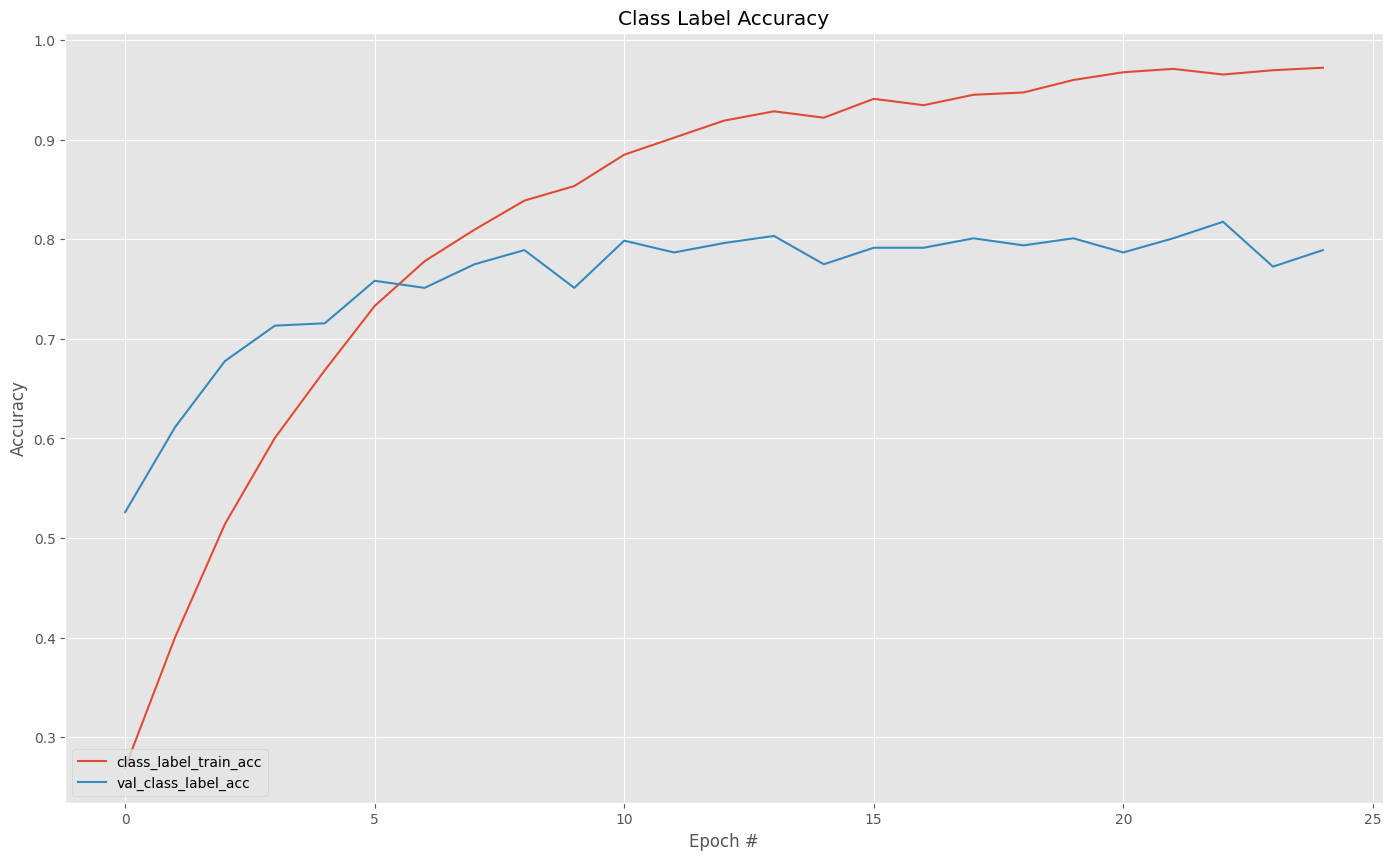

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure(figsize=(17, 10))

plt.plot(N, H.history["class_label_accuracy"],
         label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
         label="val_class_label_acc")

plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# save the accuracies plot
plotPath = os.path.sep.join(["accs.png"])
plt.savefig(plotPath)

In [ ]:
path = "testing_multiclass.txt"
filenames = open(path).read().strip().split("\n")
imagePaths = []

for f in filenames:
    imagePaths.append(f)

In [ ]:
imagePaths = '/content/1.jpg'
model = load_model("/content/model_car_detect")

In [ ]:
lb = pickle.loads(open("/content/lb.pickle", "rb").read())

In [ ]:
for imagePath in imagePaths:

    # load the input image
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # predict coordinates and classes
    (boxPreds, labelPreds) = model.predict(image)
    (startX, startY, endX, endY) = boxPreds[0]

    # determine the class label
    # with the largest predicted
    # probability
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]

    # load the input image (in OpenCV format)
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # scale the predicted bounding box
    # coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)


    # draw the predicted bounding
    # box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10

    cv2.putText(image,
                label,
                (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.65,
                (0, 255, 0),
                2)

    cv2.rectangle(image,
                  (startX, startY),
                  (endX, endY),
                  (0, 255, 0),
                  2)


    # show the output image
    imgplot = plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype('uint8'))
    plt.axis('off')
    plt.show()


1/1 [==============================] - 1s 1s/step


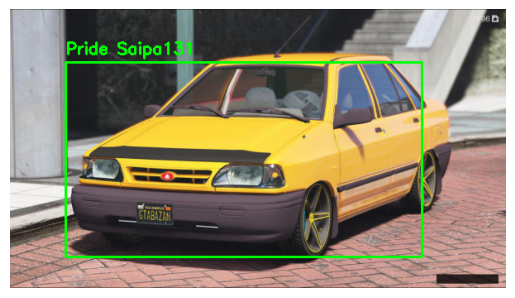

In [4]:
imagePath = '/content/3.jpg'
model = load_model("/content/drive/MyDrive/model_car_detect")
lb = pickle.loads(open("/content/drive/MyDrive/lb.pickle", "rb").read())

# load the input image
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
# predict coordinates and classes
(boxPreds, labelPreds) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]

i = np.argmax(labelPreds, axis=1)
label = lb.classes_[i][0]

# load the input image (in OpenCV format)
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# scale the predicted bounding box
# coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)


# draw the predicted bounding
# box and class label on the image
y = startY - 10 if startY - 10 > 10 else startY + 10

cv2.putText(image,
        label,
        (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.65,
        (0, 255, 0),
        2)

cv2.rectangle(image,
              (startX, startY),
              (endX, endY),
              (0, 255, 0),
              2)


# show the output image
imgplot = plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype('uint8'))
plt.axis('off')
plt.show()
